In [1]:
# Seasonal Auto Regressive Integrated Moving Average Method (SARIMA) 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sci
from sklearn.linear_model import LinearRegression
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pylab import rcParams

In [2]:
# Load data
wk = list(np.arange(1,261,1))
data = pd.read_csv("product_demand_raw.csv", names = ['demand'])
data['week'] = wk
data

,demand,week
0,29030.001,1
1,28930.000,2
2,28830.000,3
3,29020.000,4
4,27000.000,5
...,...,...
255,44509.998,256
256,44400.002,257
257,43060.001,258
258,43369.999,259


In [3]:
# Load training data
df = pd.read_csv("product_demand_raw_0.7.csv", names = ['demand'])
wk = list(np.arange(1,len(df)+1,1))
df['week'] = wk
df = df. astype(int)
df

,demand,week
0,29030,1
1,28930,2
2,28830,3
3,29020,4
4,27000,5
...,...,...
177,35990,178
178,36619,179
179,36549,180
180,35320,181


In [4]:
# x: week, y:demand 
x = df['week']
y = df['demand']

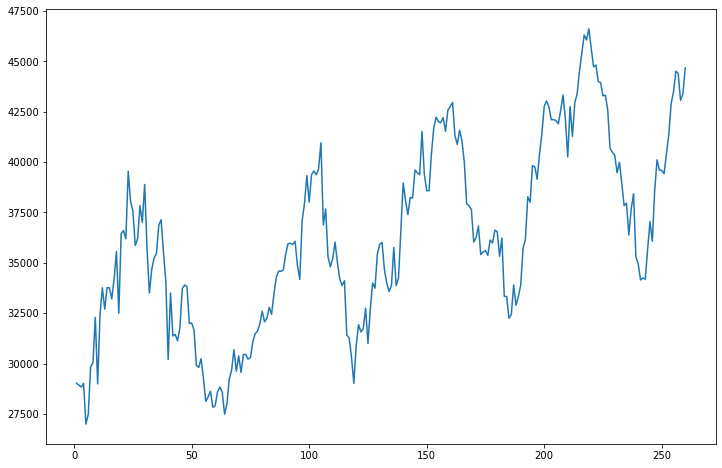

In [5]:
# Plot historical data
plt.figure(figsize=(12,8))
plt.plot(data['week'], data['demand'])
plt.show()

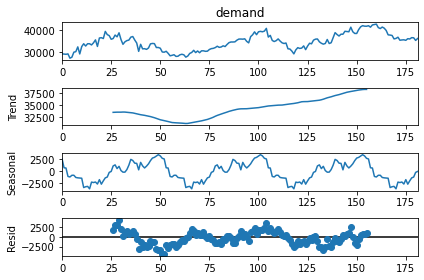

In [6]:
# Decomposition of time-series historical data in additive model
series = df['demand']
resultADD = seasonal_decompose(series, model='additive', period=52)
resultADD.plot()
plt.show()

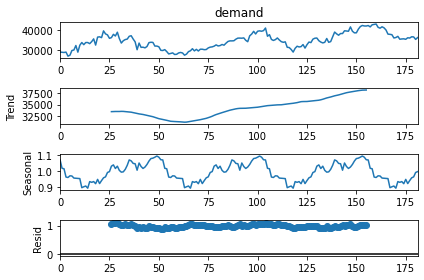

In [7]:
# Decomposition of time-series historical data in multitive model
resultMUL = seasonal_decompose(series, model='multitive', period=52)
resultMUL.plot()
plt.show()

In [8]:
# Create Function to implement grid search to test all possible combinations of variables, and print out the set that resulted in the lowest AIC
# AIC (Akaike Information Criterion) measures how well a model fits the data while taking into account the overall complexity of the model
# In general, we want to pick the combination with the lowest AIC value

import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, mini))

In [9]:
# Find the parameters with the minimum AIC
sarima_grid_search(y,52)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:inf


In [10]:
import statsmodels.api as sm

# In order to get the best prediction, it’s important to find the values of SARIMA(p,d,q)(P,D,Q)m that optimize a metric of interest
# Call this fitting function after pick the right(p,d,q) for SARIMA based on AIC               

def sarima_eva(y,order,seasonal_order,seasonal_period,pred_week,y_to_test):
    # Fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    return (results)

In [11]:
# Test data (to be evaluated)
y_to_val = np.arange(183,261,1) 

# Establish the fitting model into the fitting function 
model = sarima_eva(y,(1, 1, 1),(1, 1, 1, 52),52,78,y_to_val)

/Users/annguyen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [12]:
# Define a forecasting model based on the curve fitting model
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    # SARIMAXResults.conf_int can change alpha
    # The default alpha = .05 returns a 95% confidence interval
    pred_ci = pred_uc.conf_int()
    plt.plot(df['week'],df['demand'])
    pred_uc.predicted_mean.plot(label='Forecast')
    plt.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    plt.xlabel('Week')
    plt.ylabel('Demand')
    
    plt.plot(data['week'],data['demand'],label='historical')
    plt.legend()
    plt.show()
    
    # Produce the forcast tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Week','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Week','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Week'), on='Week')
    
    return(final_table)

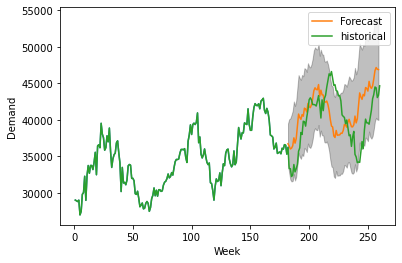

In [13]:
# Plot Forecast (yellow line) vs Actual (green line). Grey shaded area is the confidence interval of 95%
final_table = forecast(model,78,y)

In [14]:
# Save forecast data
final_table.to_csv('P_VaaT_Supporting_Documents_Q2.1_SARIMA_Forecast.csv')